# Prediction demand of bikes at each bike station at different time of the day
index = start_date, start_station_id
time period = { period 1: 1-3, 
                period 2: 4-6, 
                period 3: 7-9, 
                period 4: 10-12, 
                period 5: 13-15, 
                period 6: 16-18, 
                period 7: 19-21,
                period 8: 22-24}
peak = {period 3, period 6}

### Load the packages

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import xgboost as xgb
from geopy.distance import geodesic

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error, median_absolute_error

#  
#  
# status data

In [18]:
# load reduced status data
status = pd.read_csv("status_reduced.csv", header=None, 
                     names = ["station_id", "bikes_available", "docks_available", "datetime"],
                     parse_dates = ["datetime"])

In [19]:
status.head()

,station_id,bikes_available,docks_available,datetime
0,67,6,21,2014-11-11 00:00:00
1,48,10,4,2015-03-20 16:00:00
2,80,11,4,2015-06-29 07:00:00
3,58,3,16,2015-04-05 15:00:00
4,14,9,10,2013-11-27 06:00:00


In [20]:
# convert to datetime, seperate date and hour
# map hour to 8 time periods
status["date"] = pd.to_datetime(status.datetime, format='%m/%d/%Y %H:%M').dt.date
status["time"]=pd.to_datetime(status.datetime, format='%m/%d/%Y %H:%M').dt.hour
status["time_period"]=status.time.map(lambda x: "period " + str((x+2)//3) )

In [23]:
status.head()

,station_id,bikes_available,docks_available,datetime,date,time,time_period
0,67,6,21,2014-11-11 00:00:00,2014-11-11,0,period 0
1,48,10,4,2015-03-20 16:00:00,2015-03-20,16,period 6
2,80,11,4,2015-06-29 07:00:00,2015-06-29,7,period 3
3,58,3,16,2015-04-05 15:00:00,2015-04-05,15,period 5
4,14,9,10,2013-11-27 06:00:00,2013-11-27,6,period 2


- period 1: 1-3 
- period 2: 4-6 
- period 3: 7-9 (AM peak)
- period 4: 10-12
- period 5: 13-15 
- period 6: 16-18 (PM peak)
- period 7: 19-21
- period 8: 22-24

In [25]:
# summarize mean(bikes_available), mean(docks_available) by date, station, start_time_period
# this will be data frame used for training
status2 = status.groupby(['date','station_id','time_period']).agg({"bikes_available": "mean", "docks_available":"mean"}).reset_index()
status2.head()

,date,station_id,time_period,bikes_available,docks_available
0,2013-08-29,2,period 4,2.000000,25.000000
1,2013-08-29,2,period 5,2.000000,24.666667
2,2013-08-29,2,period 6,2.333333,24.333333
3,2013-08-29,2,period 7,1.333333,25.000000
4,2013-08-29,2,period 8,2.500000,24.000000


In [26]:
# bikes available: min=0, max=27, mean=8
# docks available: min=0, max=27, mean=8.7
status2.describe()

,station_id,bikes_available,docks_available
count,452045.000000,452045.000000,452045.000000
mean,42.526642,8.178788,9.068467
std,23.758895,3.832629,4.013591
min,2.000000,0.000000,0.000000
25%,24.000000,5.666667,6.000000
50%,42.000000,8.000000,8.666667
75%,63.000000,10.000000,11.333333
max,84.000000,27.000000,27.000000


In [29]:
# out of a total of 452045 rows, 8094 rows have bikes_available = 0 (1.8% of total)
# 61215 rows have bikes_available <=3 (13.5% of total) 
# (when average bikes_available <=3, there could be times within the 3 hour interval that bikes_available = 0)
# the situation could get worse in peak hours, peak days, high usage areas
# this justify the needs to rebalance
status.bikes_available.value_counts().sort_index()

0       8094
1      19426
2      33695
3      54656
4      78278
5     106073
6     129875
7     145670
8     139642
9     116632
10     91566
11     70491
12     54101
13     42198
14     30971
15     22895
16     17115
17     13544
18      9803
19      6790
20      5268
21      3907
22      2284
23      1050
24       410
25       283
26       107
27        10
Name: bikes_available, dtype: int64

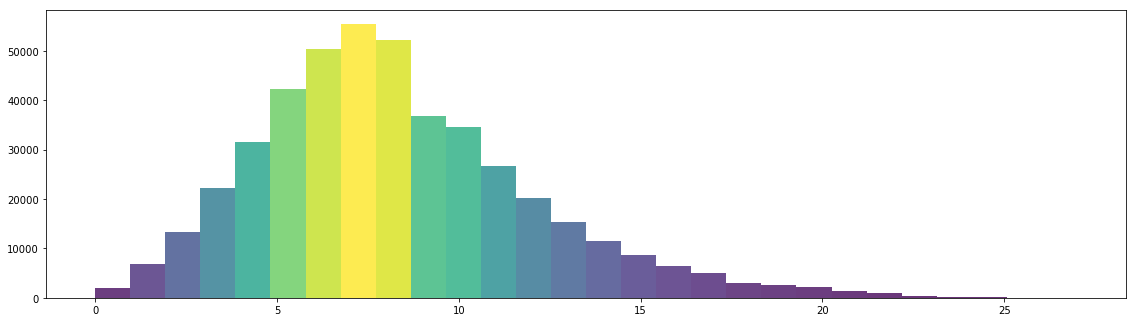

In [37]:
# plot for bikes available
# it follows a right-skewed bell curve shape, indicating normal distribution
#    - most stations have on average 6-8 bikes available at any 3 hour interval
#    - some stations have no bikes available --> shortage
#    - some stations have >15 bikes available --> under utilization
# how can we solve the problem of shortage and under utilization to maximize revenue

plt.figure(figsize=(15,4))
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
n_bins=28
N, bins, patches = plt.hist(status2.bikes_available, bins=n_bins, alpha=0.8)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
plt.show()

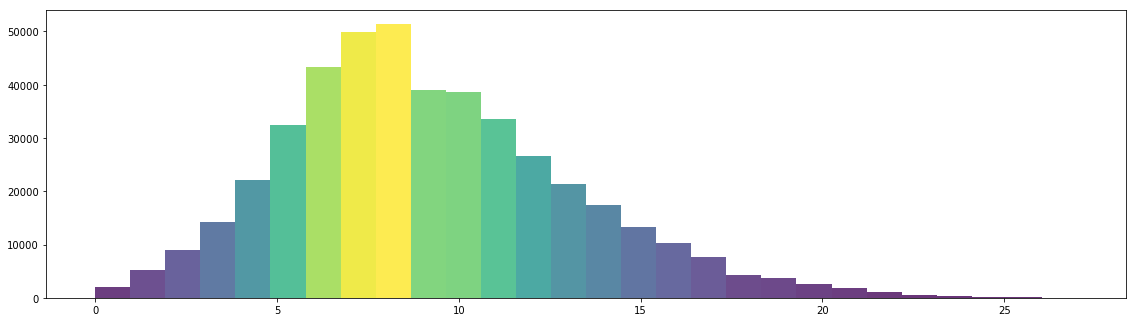

In [38]:
# plot for docks available

plt.figure(figsize=(15,4))
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
n_bins=28
N, bins, patches = plt.hist(status2.docks_available, bins=n_bins, alpha=0.8)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
plt.show()

In [39]:
# leave out duration for now
status2 = status2.iloc[:,0:4]
status2.head()

,date,station_id,time_period,bikes_available
0,2013-08-29,2,period 4,2.000000
1,2013-08-29,2,period 5,2.000000
2,2013-08-29,2,period 6,2.333333
3,2013-08-29,2,period 7,1.333333
4,2013-08-29,2,period 8,2.500000


In [40]:
status2.shape

(452045, 4)

#  
#  
# Weather data

In [42]:
# load weather data
weather = pd.read_csv("weather.csv")
weather.shape

(3665, 24)

In [43]:
# # convert to datetime, keep date only
weather.date = pd.to_datetime(weather.date, format='%m/%d/%Y').dt.date

In [44]:
#It seems we have one entry per zip code
#We need to map the stations to one of the five zip codes later
weather.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

In [45]:
# weather data has a lot of missing values
weather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

### tidy up events

In [46]:
# some weather events are in capital, some are not
# nan should mean normal weather, no special events
weather.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'], dtype=object)

In [47]:
weather.loc[weather.events == 'rain', 'events'] = "Rain"
weather.loc[weather.events.isnull(), 'events'] = "Normal"
events = pd.get_dummies(weather.events)
weather = weather.merge(events, left_index = True, right_index = True)
weather = weather.drop(['events'],1)

### tidy up max_gust_speed_mph
it has the most missing values

In [48]:
# For each value of max_wind, find the median max_gust and use that to fill the null values of max_gust
weather.loc[weather.max_gust_speed_mph.isnull(), 'max_gust_speed_mph'] = weather.groupby('max_wind_Speed_mph').max_gust_speed_mph.apply(lambda x: x.fillna(x.median()))

### tidy up precipitation_inches

In [49]:
# Change this feature from a string to numeric.
# Use errors = 'coerce' because some values currently equal 'T' and we want them to become NAs.
weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors = 'coerce')

In [50]:
# Change null values to the median, of values > 0, because T, I think, means True. 
# Therefore we want to find the median amount of precipitation on days when it rained.
weather.loc[weather.precipitation_inches.isnull(), 
            'precipitation_inches'] = weather[weather.precipitation_inches.notnull()].precipitation_inches.median()

### impute other missing values
- fill with median
- fill with 0

In [51]:
# impute other missing value with median first (to be improved later)
weather.loc[weather.max_temperature_f.isnull(), 'max_temperature_f'] = weather[weather.max_temperature_f.notnull()].max_temperature_f.median()
weather.loc[weather.mean_temperature_f.isnull(), 'mean_temperature_f'] = weather[weather.mean_temperature_f.notnull()].mean_temperature_f.median()
weather.loc[weather.min_temperature_f.isnull(), 'min_temperature_f'] = weather[weather.min_temperature_f.notnull()].min_temperature_f.median()

weather.loc[weather.max_dew_point_f.isnull(), 'max_dew_point_f'] = weather[weather.max_dew_point_f.notnull()].max_dew_point_f.median()
weather.loc[weather.mean_dew_point_f.isnull(), 'mean_dew_point_f'] = weather[weather.mean_dew_point_f.notnull()].mean_dew_point_f.median()
weather.loc[weather.min_dew_point_f.isnull(), 'min_dew_point_f'] = weather[weather.min_dew_point_f.notnull()].min_dew_point_f.median()

weather.loc[weather.max_humidity.isnull(), 'max_humidity'] = weather[weather.max_humidity.notnull()].max_humidity.median()
weather.loc[weather.mean_humidity.isnull(), 'mean_humidity'] = weather[weather.mean_humidity.notnull()].mean_humidity.median()
weather.loc[weather.min_humidity.isnull(), 'min_humidity'] = weather[weather.min_humidity.notnull()].min_humidity.median()

weather.loc[weather.max_visibility_miles.isnull(), 'max_visibility_miles'] = weather[weather.max_visibility_miles.notnull()].max_visibility_miles.median()
weather.loc[weather.mean_visibility_miles.isnull(), 'mean_visibility_miles'] = weather[weather.mean_visibility_miles.notnull()].mean_visibility_miles.median()
weather.loc[weather.min_visibility_miles.isnull(), 'min_visibility_miles'] = weather[weather.min_visibility_miles.notnull()].min_visibility_miles.median()

In [52]:
weather = weather.fillna(0)

In [53]:
# check there is no more null
weather.isnull().sum()

date                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
max_gust_speed_mph                0
precipitation_inches              0
cloud_cover                       0
wind_dir_degrees                  0
zip_code                          0
Fog                               0
Fog-Rain                          0
Normal                            0
Rain                              0
Rain-Thunderstorm           

In [54]:
# weather2 will be used for training later
weather2 = weather
weather2.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,zip_code,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,28.0,0.0,4.0,286.0,94107,0,0,1,0,0
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,35.0,0.0,2.0,291.0,94107,0,0,1,0,0
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,31.0,0.0,4.0,284.0,94107,0,0,1,0,0
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,29.0,0.0,4.0,284.0,94107,0,0,1,0,0
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,30.0,0.0,6.0,277.0,94107,0,0,1,0,0


#  
#  

# Station data
**original attributes in dataset:**
- station id: `id`
- station name: `name`
- station coordinates: `lat`, `long`
- dock count: `dock_count`
- city: `city`
- Installation date: `installation_date`

**added attributes:**
- coordinate tuple: `coords`
- mapped weather zip code: `weather_zip`

In [55]:
# load stations data from csv
stations = pd.read_csv("station.csv")
stations

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013
5,7,Paseo de San Antonio,37.333798,-121.886943,15,San Jose,8/7/2013
6,8,San Salvador at 1st,37.330165,-121.885831,15,San Jose,8/5/2013
7,9,Japantown,37.348742,-121.894715,15,San Jose,8/5/2013
8,10,San Jose City Hall,37.337391,-121.886995,15,San Jose,8/6/2013
9,11,MLK Library,37.335885,-121.885660,19,San Jose,8/6/2013


In [56]:
# stations are distributed across 5 cities in Bay area
# most stations are in San Francisco, followed by San Jose
stations.city.value_counts()

San Francisco    35
San Jose         16
Mountain View     7
Redwood City      7
Palo Alto         5
Name: city, dtype: int64

In [57]:
# there are also 5 unique zip code in weather data
# I suppose 1 zip code corresponds to 1 city
# we are going to map the stations to the nearest weather zip code to prove this
weather.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

**coordinate (lat, long) of each zip code**
- 94107: 37.7618242, -122.3985871
- 94063: 37.5021585, -122.2086579
- 94301: 37.4457966, -122.1575745
- 94041: 37.386812, -122.0751549
- 95113: 37.3326639, -121.8918364

source: https://www.freemaptools.com/convert-us-zip-code-to-lat-lng.htm

In [58]:
coords_1 = (37.7618242, -122.3985871)  # 94107
coords_2 = (37.5021585, -122.2086579)  # 94063
coords_3 = (37.4457966, -122.1575745)  # 94301
coords_4 = (37.3868120, -122.0751549)  # 94041
coords_5 = (37.3326639, -121.8918364)  # 95113

In [59]:
# combine 'lat' and 'long' into a tuple to be used for distance calculation
stations["coords"] = list(zip(stations.lat, stations.long))
stations.head()

,id,name,lat,long,dock_count,city,installation_date,coords
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,"(37.329732, -121.901782)"
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,"(37.330698, -121.888979)"
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,"(37.333988, -121.894902)"
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,"(37.331415, -121.8932)"
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,"(37.336721, -121.894074)"


In [60]:
# find the nearest weather zip code using geodesic distance (unit: km)
# https://geopy.readthedocs.io/en/stable/
stations["weather_zip"] = stations.coords.apply(lambda x: np.argmin((geodesic(coords_1, x).km,
                                                                     geodesic(coords_2, x).km,
                                                                     geodesic(coords_3, x).km,
                                                                     geodesic(coords_4, x).km,
                                                                     geodesic(coords_5, x).km)))

In [61]:
# all stations are now mapped to one of the 5 weather zip areas, using an index (0,4) representing each area
# we can see that each city corresponds to one index: 
#    0-San Francisco, 1-Redwood City, 2-Palo Alto, 3-Mountain View, 4-San Jose
# we can use either station city name or weather zip to map weather data to trips
stations

,id,name,lat,long,dock_count,city,installation_date,coords,weather_zip
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,"(37.329732, -121.901782)",4
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,"(37.330698, -121.888979)",4
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,"(37.333988, -121.894902)",4
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,"(37.331415, -121.8932)",4
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,"(37.336721, -121.894074)",4
5,7,Paseo de San Antonio,37.333798,-121.886943,15,San Jose,8/7/2013,"(37.333798, -121.886943)",4
6,8,San Salvador at 1st,37.330165,-121.885831,15,San Jose,8/5/2013,"(37.330165, -121.885831)",4
7,9,Japantown,37.348742,-121.894715,15,San Jose,8/5/2013,"(37.348742, -121.894715)",4
8,10,San Jose City Hall,37.337391,-121.886995,15,San Jose,8/6/2013,"(37.337391, -121.886995)",4
9,11,MLK Library,37.335885,-121.885660,19,San Jose,8/6/2013,"(37.335885, -121.88566)",4


In [62]:
# use a dictionary to map weather area index back to weather zip code
dic = {0:94107, 1:94063, 2:94301, 3:94041, 4:95113}
stations.replace({"weather_zip": dic}, inplace=True)

In [63]:
stations.head()

,id,name,lat,long,dock_count,city,installation_date,coords,weather_zip
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,"(37.329732, -121.901782)",95113
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,"(37.330698, -121.888979)",95113
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,"(37.333988, -121.894902)",95113
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,"(37.331415, -121.8932)",95113
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,"(37.336721, -121.894074)",95113


In [64]:
# installation date is not important for our prediction: if a station is not installed a certain date, 
# there will be no trip data for that station on that date.
# we also don't need coordinates any more, we'll drop these columns
stations2 = stations.drop(['installation_date', 'lat', 'long', 'coords'],1)

#  
#  
# merge all data into train
1. merge trip with stations, using station id as the key
2. merge trip-station with weather, using date and weather_zip as the key

In [65]:
# merge trip data with station data
train = pd.merge(status2, stations2, left_on=['station_id'], right_on=['id'])

# merge again with weather data
train = pd.merge(train, weather2, left_on=['date', 'weather_zip'], right_on=['date', 'zip_code'])

In [66]:
train = train.drop(['id','weather_zip','zip_code'], 1)
train.head()

,date,station_id,time_period,bikes_available,name,dock_count,city,max_temperature_f,mean_temperature_f,min_temperature_f,...,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,2013-08-29,2,period 4,2.000000,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,7.0,24.0,0.0,4.0,320.0,0,0,1,0,0
1,2013-08-29,2,period 5,2.000000,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,7.0,24.0,0.0,4.0,320.0,0,0,1,0,0
2,2013-08-29,2,period 6,2.333333,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,7.0,24.0,0.0,4.0,320.0,0,0,1,0,0
3,2013-08-29,2,period 7,1.333333,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,7.0,24.0,0.0,4.0,320.0,0,0,1,0,0
4,2013-08-29,2,period 8,2.500000,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,7.0,24.0,0.0,4.0,320.0,0,0,1,0,0


#  
#  
# Special Dates

In [67]:
# Find all of the holidays during our time span
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=train.date.min(), end=train.date.max())
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date
holidays

array([datetime.date(2013, 9, 2), datetime.date(2013, 10, 14),
       datetime.date(2013, 11, 11), datetime.date(2013, 11, 28),
       datetime.date(2013, 12, 25), datetime.date(2014, 1, 1),
       datetime.date(2014, 1, 20), datetime.date(2014, 2, 17),
       datetime.date(2014, 5, 26), datetime.date(2014, 7, 4),
       datetime.date(2014, 9, 1), datetime.date(2014, 10, 13),
       datetime.date(2014, 11, 11), datetime.date(2014, 11, 27),
       datetime.date(2014, 12, 25), datetime.date(2015, 1, 1),
       datetime.date(2015, 1, 19), datetime.date(2015, 2, 16),
       datetime.date(2015, 5, 25), datetime.date(2015, 7, 3)], dtype=object)

In [68]:
#Find all of the business days in our time span
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.DatetimeIndex(start=train.date.min(), end=train.date.max(), freq=us_bd)
business_days = pd.to_datetime(business_days, format='%Y/%m/%d').date
business_days

array([datetime.date(2013, 8, 29), datetime.date(2013, 8, 30),
       datetime.date(2013, 9, 3), datetime.date(2013, 9, 4),
       datetime.date(2013, 9, 5), datetime.date(2013, 9, 6),
       datetime.date(2013, 9, 9), datetime.date(2013, 9, 10),
       datetime.date(2013, 9, 11), datetime.date(2013, 9, 12),
       datetime.date(2013, 9, 13), datetime.date(2013, 9, 16),
       datetime.date(2013, 9, 17), datetime.date(2013, 9, 18),
       datetime.date(2013, 9, 19), datetime.date(2013, 9, 20),
       datetime.date(2013, 9, 23), datetime.date(2013, 9, 24),
       datetime.date(2013, 9, 25), datetime.date(2013, 9, 26),
       datetime.date(2013, 9, 27), datetime.date(2013, 9, 30),
       datetime.date(2013, 10, 1), datetime.date(2013, 10, 2),
       datetime.date(2013, 10, 3), datetime.date(2013, 10, 4),
       datetime.date(2013, 10, 7), datetime.date(2013, 10, 8),
       datetime.date(2013, 10, 9), datetime.date(2013, 10, 10),
       datetime.date(2013, 10, 11), datetime.date(2013, 10,

In [69]:
# map date to business_day and holiday, convert to binary variables
train['business_day'] = train.date.isin(business_days)
train['holiday'] = train.date.isin(holidays)
#Convert True to 1 and False to 0
train.business_day = train.business_day.map(lambda x: 1 if x == True else 0)
train.holiday = train.holiday.map(lambda x: 1 if x == True else 0)

In [70]:
#Convert date to the important features, year, month, weekday (0 = Monday, 1 = Tuesday...)
train['year'] = pd.to_datetime(train['date']).dt.year
train['month'] = pd.to_datetime(train['date']).dt.month
train['weekday'] = pd.to_datetime(train['date']).dt.weekday
train.head()

,date,station_id,time_period,bikes_available,name,dock_count,city,max_temperature_f,mean_temperature_f,min_temperature_f,...,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,business_day,holiday,year,month,weekday
0,2013-08-29,2,period 4,2.000000,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,0,0,1,0,0,1,0,2013,8,3
1,2013-08-29,2,period 5,2.000000,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,0,0,1,0,0,1,0,2013,8,3
2,2013-08-29,2,period 6,2.333333,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,0,0,1,0,0,1,0,2013,8,3
3,2013-08-29,2,period 7,1.333333,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,0,0,1,0,0,1,0,2013,8,3
4,2013-08-29,2,period 8,2.500000,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,0,0,1,0,0,1,0,2013,8,3


In [71]:
train.shape

(452045, 38)

In [72]:
# here's the list of 38 columns in train
list(train)

['date',
 'station_id',
 'time_period',
 'bikes_available',
 'name',
 'dock_count',
 'city',
 'max_temperature_f',
 'mean_temperature_f',
 'min_temperature_f',
 'max_dew_point_f',
 'mean_dew_point_f',
 'min_dew_point_f',
 'max_humidity',
 'mean_humidity',
 'min_humidity',
 'max_sea_level_pressure_inches',
 'mean_sea_level_pressure_inches',
 'min_sea_level_pressure_inches',
 'max_visibility_miles',
 'mean_visibility_miles',
 'min_visibility_miles',
 'max_wind_Speed_mph',
 'mean_wind_speed_mph',
 'max_gust_speed_mph',
 'precipitation_inches',
 'cloud_cover',
 'wind_dir_degrees',
 'Fog',
 'Fog-Rain',
 'Normal',
 'Rain',
 'Rain-Thunderstorm',
 'business_day',
 'holiday',
 'year',
 'month',
 'weekday']

#  
#  
# Train the model

In [73]:
# convert categorical variables to one-hot representation, as required by scikit learn
time_period = pd.get_dummies(train.time_period)
station_id = pd.get_dummies(train.station_id)
city = pd.get_dummies(train.city)

In [74]:
train = train.merge(time_period, left_index = True, right_index = True)
train = train.merge(city, left_index = True, right_index = True)
train = train.merge(station_id, left_index = True, right_index = True)

In [75]:
train = train.drop(['time_period','station_id','city','name','date'],1)

In [76]:
train.describe()

,bikes_available,dock_count,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,...,72,73,74,75,76,77,80,82,83,84
count,452045.000000,452045.000000,452045.000000,452045.000000,452045.000000,452045.000000,452045.000000,452045.00000,452045.000000,452045.000000,...,452045.000000,452045.000000,452045.000000,452045.000000,452045.000000,452045.000000,452045.000000,452045.000000,452045.000000,452045.000000
mean,8.178788,17.715336,69.945981,61.095988,51.906122,52.759772,48.753836,44.50143,85.673055,67.529536,...,0.014549,0.014463,0.014549,0.014549,0.014549,0.014549,0.012081,0.011647,0.011065,0.010132
std,3.832629,3.990183,8.114152,6.852748,7.022960,6.322607,7.353652,9.01759,8.821702,10.567253,...,0.119740,0.119390,0.119740,0.119740,0.119740,0.119740,0.109246,0.107291,0.104608,0.100145
min,0.000000,11.000000,44.000000,38.000000,25.000000,20.000000,13.000000,2.00000,24.000000,24.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.666667,15.000000,64.000000,56.000000,47.000000,49.000000,45.000000,40.00000,82.000000,62.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,15.000000,70.000000,61.000000,53.000000,54.000000,49.000000,46.00000,86.000000,69.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,19.000000,75.000000,67.000000,57.000000,57.000000,55.000000,52.00000,93.000000,74.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,27.000000,27.000000,102.000000,84.000000,75.000000,68.000000,65.000000,63.00000,100.000000,96.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [77]:
labels = train.iloc[:,0]
labels.head()

0    2.000000
1    2.000000
2    2.333333
3    1.333333
4    2.500000
Name: bikes_available, dtype: float64

In [78]:
features = train.iloc[:,1:]
features.head()

,dock_count,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,72,73,74,75,76,77,80,82,83,84
0,27,81.0,72.0,63.0,62.0,61.0,59.0,87.0,69.0,51.0,...,0,0,0,0,0,0,0,0,0,0
1,27,81.0,72.0,63.0,62.0,61.0,59.0,87.0,69.0,51.0,...,0,0,0,0,0,0,0,0,0,0
2,27,81.0,72.0,63.0,62.0,61.0,59.0,87.0,69.0,51.0,...,0,0,0,0,0,0,0,0,0,0
3,27,81.0,72.0,63.0,62.0,61.0,59.0,87.0,69.0,51.0,...,0,0,0,0,0,0,0,0,0,0
4,27,81.0,72.0,63.0,62.0,61.0,59.0,87.0,69.0,51.0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
# split into training 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state = 2)

In [83]:
# our data has 116 features
# training data has 361636 samples
# test data has 90409 samples
print(X_train.shape)
print(X_test.shape)

(361636, 116)
(90409, 116)


In [81]:
#10 fold cross validation. Multiply by -1 to make values positive.
#Used median absolute error to learn how many trips my predictions are off by.

def scoring(clf):
    scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=1, scoring = 'neg_median_absolute_error')
    print (np.median(scores) * -1)

In [ ]:
rfr = RandomForestRegressor(n_estimators = 10, # to be tuned
                            min_samples_leaf = 3,
                            random_state = 2)
scoring(rfr)

In [ ]:
gbr = GradientBoostingRegressor(learning_rate = 0.12,
                                n_estimators = 100,
                                max_depth = 8,
                                min_samples_leaf = 1,
                                random_state = 2)
scoring(gbr)

In [ ]:
dtr = DecisionTreeRegressor(min_samples_leaf = 3,
                            max_depth = 8,
                            random_state = 2)
scoring(dtr)

In [ ]:
abr = AdaBoostRegressor(n_estimators = 100,
                        learning_rate = 0.1,
                        loss = 'linear',
                        random_state = 2)
scoring(abr)

In [ ]:
# xgboost
import warnings
warnings.filterwarnings("ignore")

random_state = 2
params = {
        'eta': 0.15,
        'max_depth': 6,
        'min_child_weight': 2,
        'subsample': 1,
        'colsample_bytree': 1,
        'verbose_eval': True,
        'seed': random_state,
    }

n_folds = 10 #number of Kfolds
cv_scores = [] #The sum of the mean_absolute_error for each fold.
early_stopping_rounds = 100
iterations = 10000
printN = 50
fpred = [] #stores the sums of predicted values for each fold.

testFinal = xgb.DMatrix(X_test)

kf = KFold(len(X_train), n_folds=n_folds)

for i, (train_index, test_index) in enumerate(kf):
    print('\n Fold %d' % (i+1))
    Xtrain, Xval = X_train.iloc[train_index], X_train.iloc[test_index]
    Ytrain, Yval = y_train.iloc[train_index], y_train.iloc[test_index]
    
    xgtrain = xgb.DMatrix(Xtrain, label = Ytrain)
    xgtest = xgb.DMatrix(Xval, label = Yval)
    watchlist = [(xgtrain, 'train'), (xgtest, 'eval')] 
    
    xgbModel = xgb.train(params, 
                         xgtrain, 
                         iterations, 
                         watchlist,
                         verbose_eval = printN,
                         early_stopping_rounds=early_stopping_rounds
                        )
    
    scores_val = xgbModel.predict(xgtest, ntree_limit=xgbModel.best_ntree_limit)
    cv_score = median_absolute_error(Yval, scores_val)
    print('eval-MSE: %.6f' % cv_score)
    y_pred = xgbModel.predict(testFinal, ntree_limit=xgbModel.best_ntree_limit)
    print(xgbModel.best_ntree_limit)

    if i > 0:
        fpred = pred + y_pred #sum predictions
    else:
        fpred = y_pred
    pred = fpred
    cv_scores.append(cv_score)

xgb_preds = pred / n_folds #find the average values for the predictions
score = np.median(cv_scores)
print('Median error: %.6f' % score)

In [ ]:
#Train and make predictions with the best models.
rfr = rfr.fit(X_train, y_train)
gbr = gbr.fit(X_train, y_train)

rfr_preds = rfr.predict(X_test)
gbr_preds = gbr.predict(X_test)

#Weight the top models to find the best prediction
final_preds = rfr_preds*0.32 + gbr_preds*0.38 + xgb_preds*0.3
print ("Daily error of trip count:", median_absolute_error(y_test, final_preds))

In [ ]:
#A reminder of the range of values in number of daily trips.
labels.describe()

In [ ]:
labels.median()

In [ ]:
y_test.reset_index(drop = True, inplace = True)

In [ ]:
fs = 16
plt.figure(figsize=(50,10))
plt.plot(final_preds)
plt.plot(y_test)
plt.legend(['Prediction', 'Acutal'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Predicted Date", fontsize = fs)
plt.title("Predicted Values vs Actual Values", fontsize = fs)
plt.show()
# too much data point, hard to see
# need to find better way to plot

In [ ]:
#Create a plot that ranks the features by importance.
def plot_importances(model, model_name):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for feature in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]    

    # Plot the feature importances of the forest
    plt.figure(figsize = (50,5))
    plt.title("Feature importances of " + model_name)
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

In [ ]:
# Print the feature ranking
print("Feature ranking:")

i = 0
for feature in X_train:
    print (i, feature)
    i += 1
    
plot_importances(rfr, "Random Forest Regressor")
plot_importances(gbr, "Gradient Boosting Regressor")

For random forest model, top 10 important features are:
- 99: station id 70
- 27: business_day
- 38: period 6
- 0: dock_count
- 35: period 3
- 114: city = San Francisco
- 29: year
- 31: weekday

For gradient boosting model, top 10 important features are:
- 35: period 3
- 38: period 6
- 31: weekday
- 27: business_day
- 29: year
- 99: station id = 70
- 21: wind_dir_degrees
- 30: month
- 114: city = San Fransico
- 0: dock_count


# Observation
- top important features are very much consistent in different models
- weather is not an important factor in bike usage in Bay area (I believe the conclusion will be very different for Singapore)
- important factors like peak hours, business day, weekday are very predictable/known before hand --> future demand for bikes can be predicted at a very early time with high accuracy --> allow early planning (contrary to Singapore, if weather is an important factor, bike sharing companies can only predict demand for a few hours ahead, less planning time  --> this might be the reason that Singapore bike sharing companies have decided to adopt a dockless system)
- San Fransico has higher demand than other cities
- dock_count is an important factor --> this will only be the case when demand > #docks, which indicate to us that rebalancing is needed
- certain station ids appear as top 10 important features --> this indicate to us that demand at these stations are constantly higher regardless of day and time of the day --> constant rebalancing is required at these stations --> it will be interesting to see position of these few stations (id=70, 69, 50)


In [ ]:
final_preds.shape

In [ ]:
output = X_test

In [ ]:
output["bikes_available_actual"] = y_test.values
output["bikes_available_predicted"] = final_preds

In [ ]:
output

In [ ]:
output.to_csv("prediction output/Bike availability prediction output.csv", encoding='utf-8', index=False)